<a href="https://colab.research.google.com/github/ccg-esb/EvK/blob/main/py_pOXA48_SI1_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

### __SI:__ Differences in vertical and horizontal transmission dynamics shape plasmid distribution in clinical enterobacteria

This notebook presents a plasmid population dynamics model that enables us to investigate the behavior of bacterial populations under antibiotic treatment through computational simulations. The primary focus is on studying the dynamics of plasmid-bearing populations and their response to antibiotics in varying environmental conditions.

The model takes into account factors such as plasmid transfer, segregational loss, and antibiotic-induced selection pressure. By simulating different scenarios, we can observe how these mechanisms shape the dynamics of plasmid populations and the overall response of bacterial populations to antibiotics.


In [ ]:
# User-defined parameters
B0 = 1e6 #Initial bacterial density
T = 24 #Duration of experimental season
S0 = 1 #Concentration of imiting resource
d = 0.1 #Transfer dilution rate
seg_rate = .1 #Segregation rate
extinction_threshold=1 #Extinction threshold
alphas=[1e-8, 1e-10] #Antibiotic degradation rate

MIC_max=1 #Maximum antibiotic concentrations=[32768, 256, 1024, 32]

Vkm_p=5.45259e-10
rho_p=8.70403e+08
kappa_p=0.9

VKm_0=6.19564e-10
rho_0=8.71786e+08
kappa_0=0.2
conj_rate=0.02

model_params = {
    'B0': B0, #Initial bacterial density
    'T': T,  # Length of experiment
    'S0': S0,  # Resource concentration
    'd': d, #Transfer dilution rate
    'extinction_threshold': extinction_threshold,
}


# Modelling Plasmid-Driven Antibiotic Resistance

Our goal is to postulate a mathematical model that captures the ecological dynamics of a bacterial population comprised of plasmid-bearing and plasmid-free strains in a homogeneous environment. The model represents the bacterial population's density at time $t$ as $B(t)$, which competes for a single limiting resource, with concentration denoted with $S(t)$.

## 1.1 Modelling Bacterial Growth

We consider that growth of each bacterial strain is dictated by several key parameters: the maximum uptake rate ($V_{\text{max}}$), the half-saturation constant ($K_m$), and a resource conversion coefficient ($\rho$). These parameters define the Monod term, which encapsulates the fundamental growth kinetics of bacterial strains[ref].

The uptake function $\mathit{U}(S)$, represented by the equation
$$\mathit{U}(S) = \frac{{V_{\text{max}} \cdot S}}{{S + K_m}},$$

determines how the population consumes the limiting resource. The half-saturation constant $K_m$ signifies the resource concentration at which the uptake rate is half of its maximum, hence providing a measure of the affinity of the bacteria for the resource. A low $K_m$ implies a high affinity, meaning the bacteria can utilize the resource effectively even at low concentrations.

Previous studies have established that it is challenging to simultaneously identify the parameters $V_{\text{max}}$ and $K_m$. With our aim being to calibrate these parameters using experimental data, we will use the $V_{\text{max}}/K_m$ ratio, commonly known as the 'specific affinity'. This ratio represents the ability of a strain to sequester and metabolize the resource relative to its saturation level. Importantly, the 'specific affinity' has been demonstrated to be structurally identifiable.

The other parameter relevant for the growth dynamics is the conversion coefficient $\rho$, which represents the efficiency with which cells convert the consumed resources into new biomass, determining the bacterial population's growth rate per unit of resource consumed.
The growth function can thus be expressed as $G(S; \psi)=\rho \cdot U(S)$, with $\psi=(\rho, V_{\text{max}}/K_m)$ representing a vector of parameters that characterize the growth dynamics of a particular bacterial strain.

The Python function uS(S, VKm) approximates the uptake function $\mathit{U}(S)$ described above.

In [ ]:

# This function calculates the uptake rate u based on the resource concentration R
# and the Michaelis-Menten constant VKm.
def uS(S, VKm):
    return (S * VKm) / (1 + S)

## Modeling the Dynamics of Plasmid-bearing and Plasmid-free Bacterial Populations

Plasmids are small, circular pieces of DNA that replicate independently of the bacterial chromosome. They often carry genes providing adaptive traits to their bacterial hosts, such as antibiotic resistance. Thus, a bacterial population may be divided into two distinct subpopulations: plasmid-bearing cells ($B_p$) and plasmid-free cells ($B_\emptyset$). The presence or absence of plasmids within these subpopulations can significantly impact their overall behavior and response to environmental stressors, such as antibiotics[ref].

In our model, we assign $B_p$ and $B_\emptyset$ fixed, but distinct, growth kinetic parameters. Adjusting these parameters allows our model to emulate a range of fitness effects associated with plasmid-bearing, from costs to benefits[ref]. It's worth mentioning that while fitness costs can be compensated over time[ref], we consider them constant in our model for simplification.

In [ ]:
def plot_uptake(S_values, VKm_values):
    num_strains = int(len(VKm_values)/2)

    plt.subplots(figsize=(4, 3))  # Set the figsize to your desired smaller size

    growth_rates = [uS(S, VKm_values[0]) for S in S_values]
    plt.plot(S_values, growth_rates, alpha=1, color='k', label=r'$B_p$') #, label=f'{codes[i+1]}'

    growth_rates = [uS(S, VKm_values[1]) for S in S_values]
    plt.plot(S_values, growth_rates, '--', alpha=1, color='k', label=r'$B_{\emptyset}$') #, label=f'{codes[i+1]}'

    plt.xlabel(r'Resource concentration, $S$', fontsize=14)
    plt.ylabel(r'Uptake Rate, $u(S)$', fontsize=14)
    plt.legend(fontsize=12)
    plt.tick_params(axis='x', labelsize=12)
    plt.tick_params(axis='y', labelsize=12)
    plt.show()


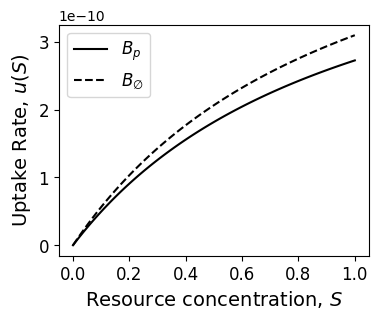

In [ ]:
model_params['strain']=['B', 'B']
model_params['type']=['TC', 'WT'] #Plasmid-bearing, plasmid-free
model_params['VKm']=[Vkm_p, VKm_0] #Specific affinity (Vmax/Km)
model_params['rho']=[rho_p, rho_0] #Half saturation constant

S_values = np.linspace(0, 1, 100)  # Example S values from 0 to 10
plot_uptake(S_values, model_params['VKm'])

## Plasmid segregation

In addition to growth dynamics, our model accounts for the intrinsic processes occurring within plasmid-bearing bacterial cells. One crucial aspect is the segregational loss of plasmids, a random event that occurs during bacterial cell division. As a plasmid-bearing cell divides, it distributes its plasmids to its two offspring cells. Given the probabilistic nature of this distribution, there are instances when one of the offspring cells may not inherit a plasmid, thereby converting it into a plasmid-free cell. This stochastic event, denoted as 'segregational loss', represents an essential dynamic contributing to the overall plasmid count within the bacterial population. The rate at which this loss occurs is captured by a parameter $\lambda$ in our model and implemented in Python with this function:

In [ ]:
model_params['seg_rate']=[seg_rate, np.NaN] #Segregation rate (only for plasmid-bearing)

def dB_seg(B_TC, seg_rate, uSi_TC):
    # Calculate segregational loss rate, only applicable for plasmid-bearing population
    if np.isnan(seg_rate):
        seg_rate = 0
    return seg_rate * uSi_TC * B_TC

## Plasmid conjugation

The model also considers the horizontal transfer of plasmids between cells through conjugation. We consider a well-mixed environment whereby the mass-action principle holds, so the rate of conjugation is assumed to be proportional to the densities of both plasmid-bearing and plasmid-free cells. The conjugation rate is symbolized as $\gamma$, a parameter reflecting the receptivity or permissiveness of the recipient cell to the incoming plasmid.

This function calculates the net change in the plasmid-bearing bacterial population due to conjugation events, taking into account the densities of both the plasmid-free (B_WT) and plasmid-bearing (B_TC) populations and the conjugation rate (conj_rate):

In [ ]:
model_params['conj_rate']=[conj_rate, np.NaN] # Conjugation rates (only for plasmid-bearing)

def dB_conj_single(B_WT, B_TC, conj_rate):
    if np.isnan(conj_rate): # Below detectable limits
        conj_rate = 0
    ret = conj_rate * B_WT * B_TC
    return ret

## Modelling the action of bactericidal antibiotics

Our model incorporates the impact of antibiotic resistance on bacterial populations. Specifically, it represents the antibiotic concentration at any given time $t$ as $A(t)$. We are dealing with bactericidal antibiotics, such as beta-lactam antibiotics, that are subject to enzymatic degradation. The model includes an inactivation rate for antibiotic molecules, which is assumed to be proportional to the total bacterial population and the environmental antibiotic concentration. We consider the rate of degradation to be higher for plasmid-bearing cells, $\alpha_p>\alpha_{\emptyset}\geq0$.

To model the reduced death rate due to the antibiotic in plasmid-bearing cells, our model assumes a linear relationship between plasmid copy number (PCN) and the degree of antibiotic killing. This is represented through the parameter $\kappa_p > \kappa_\emptyset > 0$, which quantifies the intrinsic resistance of a bacterial strain against the antibiotic. A higher $\kappa$ value denotes greater resistance levels. Conversely, lower values of $\kappa$ suggest greater susceptibility, indicating that even low antibiotic concentrations can effectively kill the bacterial population.

This relationship is encapsulated in the following function, where the antibiotic-induced death rate is calculated. This function computes the effective killing rate of the antibiotic as the reciprocal of the product of kappa and the maximum inhibitory concentration (MIC_max).

In [ ]:
model_params['kappa']=[kappa_p, kappa_0] #Drug resistance coefficient
model_params['MIC_max']=MIC_max          #Maximum drug used
model_params['alphas']=np.array(alphas)  #Antibiotic degradation rate

def dB_kill(A, Bs, kappa, MIC_max):
    kill_rate = 1 / (kappa*MIC_max)
    return kill_rate * A * Bs

## Plasmid population dynamics model

Altogether, our model captures the dynamics of a bacterial population composed of two distinct subpopulations: plasmid-bearing ($B_p$) and plasmid-free ($B_\emptyset$) cells. Both subpopulations compete for a limiting resource, $S$, and are susceptible to an antibiotic, $A$. The interplay between vertical and horizontal transmission routes via segregational loss and conjugation, respectively, plays a significant role in shaping the plasmid distribution and persistence within these subpopulations over time.

We describe the system through a set of differential equations, which encapsulate the temporal evolution of the system state $\bar{x}=(S, A, B_\emptyset, B_p)$, and that can be written as:

\begin{align}
\frac{dS}{dt}&=-\left(\mathit{U}(S; \psi_\emptyset) \cdot B_\emptyset + \mathit{U}(S; \psi_p) \cdot B_p\right),\\
\frac{dA}{dt}&=-A\cdot (\alpha_\emptyset B_\emptyset + \alpha_p B_p),\\
\frac{dB_\emptyset}{dt}&= \left(G(S; \psi_\emptyset) - \kappa_\emptyset A \right) \cdot B_\emptyset + \lambda \, G(S; \psi_p)\cdot B_p  - \gamma \, B_\emptyset \, B_p ,\\
\frac{dB_p}{dt}&= \left(G(S; \psi_p) - \kappa_p A \right) \cdot B_p - \lambda \, G(S; \psi_p)\cdot B_p  + \gamma \, B_\emptyset \, B_p.
\end{align}


The initial conditions are determined by the starting resource concentration, which is set to $S_0=1$ throughout our study, and the environmental drug concentration, denoted as $A \geq 0$. The initial densities of $B_p(0)$ and $B_\emptyset (0)$ are given by the specific experimental setup being simulated. In particular, we simulate two types of experiments: plasmid invasion experiments, where the majority of the population consists of $B_\emptyset$ cells and a minor fraction is plasmid-bearing, and competition experiments, where the population begins with equal numbers of $B_p$ and $B_\emptyset$ cells.






In [ ]:
# This function implements a set of ordinary differential equations describing
# the population dynamics of plasmid-bearing (TC) and plasmid-free (WT) cells
# competing for a limiting resource and exposed to a bactericidal antibiotic.
# State variables are Resource (S) and Antibiotic (A) concentrations,
# and Densities of Plasmid-bearing (B_TC) and Plasmid-free (B_WT) bacteria.
def fsinglestrain(t, y, params):
    S = y[0]
    A = y[1]
    B_TC = y[2]
    B_WT = y[3]

    # For plasmid-bearing (TC)
    uSi_TC = uS(S, params['VKm'][0])
    uStot_TC = uSi_TC * B_TC

    dB_TC_growth = params['rho'][0] * uSi_TC * B_TC
    dB_TC_seg = dB_seg(B_TC, params['seg_rate'][0], uSi_TC)

    # For plasmid-free (WT)
    db_MIC_TC = params['kappa'][0]
    dB_TC_kill = dB_kill(A, B_TC, db_MIC_TC, params['MIC_max'])
    dB_WT_seg= dB_seg(B_TC, params['seg_rate'][0], uSi_TC)

    conj_permissiveness = params['conj_rate'][1] # permissiveness of WT
    dB_TC_conj = dB_conj_single(B_WT, B_TC, conj_permissiveness)

    dB_TC = dB_TC_growth + dB_TC_conj - dB_TC_seg - dB_TC_kill

    # For plasmid-free (WT)
    uSi_WT = uS(S, params['VKm'][1])
    uStot_WT = uSi_WT * B_WT

    dB_WT_growth = params['rho'][1] * uSi_WT * B_WT

    db_MIC_WT = params['kappa'][1]
    dB_WT_kill = dB_kill(A, B_WT, db_MIC_WT, params['MIC_max'])

    dB_WT_seg= params['rho'][0] * uSi_TC * B_TC * params['seg_rate'][0]

    conj_permissiveness = params['conj_rate'][1] # permissiveness of WT
    dB_WT_conj = dB_conj_single(B_WT, B_TC, conj_permissiveness)

    dB_WT = dB_WT_growth - dB_WT_conj - dB_WT_kill + dB_WT_seg

    dS =  - (uStot_TC + uStot_WT)
    dA = -A * (params['alphas'][0] * B_TC + params['alphas'][1] * B_WT)

    return np.array([dS, dA, dB_TC, dB_WT])

In [ ]:
#The function simulate_model(model_params, y0) runs the simulation of our model
#by solving the system of ordinary differential equations (ODEs).
#It uses the solve_ivp method from the SciPy library with backward differentiation,
#returning the time points and corresponding solution vectors.
def simulate_model(model_params, y0):

    t_span = [0, model_params['T']]

    # Solve the ODE
    sol = solve_ivp(fsinglestrain, t_span, y0, args=(model_params,), method='BDF', max_step=0.1, rtol=1e-5, atol=1e-8)

    # Extract the time points and solution vectors
    times = sol.t
    ys = sol.y

    return times, ys



In [ ]:
#The plot_simulation(t, ys) function generates three plots to visualize
#the simulation results: the first plot shows the resource and antibiotic
#concentrations over time; the second plot depicts the density of the
#plasmid-bearing and plasmid-free strains over time; the third plot
#illustrates the relative abundance of each strain over time.
def plot_simulation(t, ys):
    fig, axs = plt.subplots(1, 3, figsize=(12,3))

    S = ys[0]
    A = ys[1]
    B_TC = ys[2]
    B_WT = ys[3]
    B_total=B_TC+B_WT

    axs[1].plot(t, B_TC,'-', label='TC', color='k')

    axs[1].plot(t, B_WT, ':', label='WT', color='k')

    # Plot bacterial density
    axs[0].plot(t, S, label='Resource')
    axs[0].plot(t, A, label='Antibiotic (units of MIC)')

    axs[0].set_xlabel('Time (hours)', fontsize=12)
    axs[0].set_ylabel('Concentration', fontsize=12)
    axs[0].set_ylim([-0.05,1.1])

    axs[1].set_xlabel('Time (hours)', fontsize=12)
    axs[1].set_ylabel('Density (cells/ml)', fontsize=12)

    # Calculate relative abundance of each strain
    rel_B_TC = B_TC / B_total
    rel_B_WT = B_WT / B_total

    # Plot relative abundance
    axs[2].plot(t, rel_B_TC, '-', label='TC', color='k')
    axs[2].plot(t, rel_B_WT, ':', label='WT', color='k')

    axs[2].set_xlabel('Time (hours)', fontsize=12)
    axs[2].set_ylabel('Relative Abundance', fontsize=12)

    axs[0].legend()
    axs[2].legend()



# Numerical examples

As an example, we will evaluate a drug-free scenario by setting the initial environmental antibiotic concentration, denoted as $A$, to 0. The simulation's initial conditions are defined by the variable $y_0 = (S_0, A, 0, B_0)$, which represents the initial substrate concentration ($S_0$), the environmental antibiotic concentration ($A$), and the initial bacterial density. In this particular example, we assume that all cells in the population are plasmid-free, and their density is denoted as $B_0$.

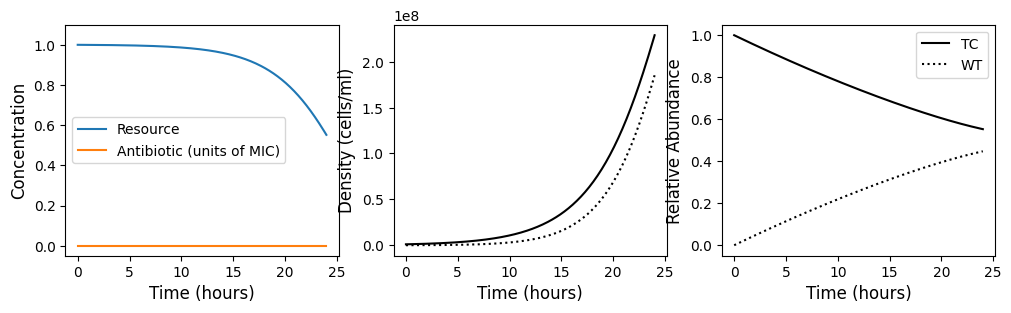

In [ ]:
# Run the simulation (drug free, plasmid-bearing)
A=0. #Environmental drug concentration
y0 = np.concatenate(([S0],[A], [B0, 0.]))
times, ys = simulate_model(model_params, y0)
plot_simulation(times, ys)

By modifying the initial densities, we can examine the dynamics of the plasmid-bearing population ($B_p$). It is important to note that, in this case, a significant fraction of the population becomes plasmid-free by the end of the experiment. This phenomenon arises due to the occurrence of segregational loss, which favors the emergence of plasmid-free cells with reduced cost associated with bearing plasmids.

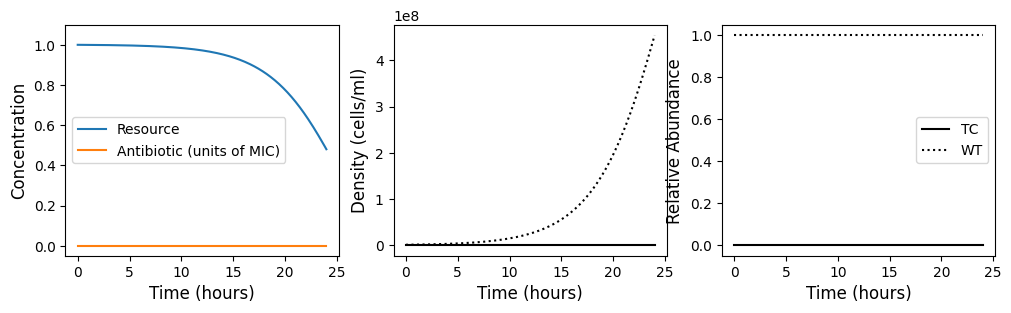

In [ ]:
# Run the simulation (drug free, Plasmid-free)
A=0. #Environmental drug concentration
y0 = np.concatenate(([S0],[A], [0., B0]))
times, ys = simulate_model(model_params, y0)
plot_simulation(times, ys)

In this second example, the environmental antibiotic concentration is set to $A>0$, indicating that the bacterial populations are now subject to antibiotic pressure. Under these conditions, the plasmid-bearing population outperforms the plasmid-free cells due to their enhanced resistance to the antibiotic. The survival advantage of the plasmid-bearing cells is depicted in the resulting plot, showing the role of plasmids by allowing the $B_p$ cells to proliferate when $A=0.2$. Also note that a small fraction of plasmid-free cells is maintained through segregational loss.

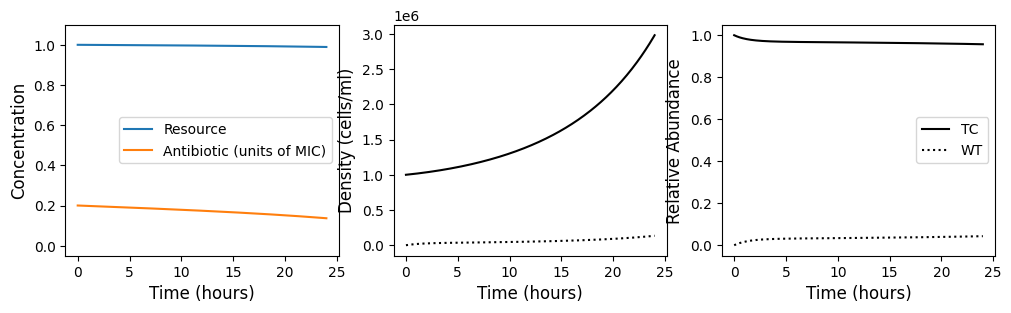

In [ ]:
# Run the simulation
A=0.2 #Environmental drug concentration
y0 = np.concatenate(([S0],[A], [B0, 0]))
times, ys = simulate_model(model_params, y0)
plot_simulation(times, ys)

In contrast, performing a similar numerical experiment with plasmid-free cells highlights that the antibiotic leads to the eradication of the entire $B_{\emptyset}$ population.

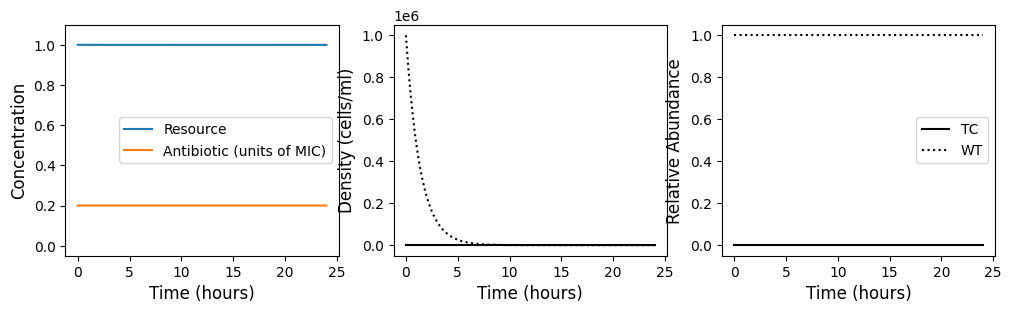

In [ ]:
# Run the simulation
A=0.2 #Environmental drug concentration
y0 = np.concatenate(([S0],[A], [0, B0]))
times, ys = simulate_model(model_params, y0)
plot_simulation(times, ys)

# Computer simulations: Drug-response experiment

To numerically evaluate the susceptibility of a bacterial population, we can conduct drug response experiments using computer simulations. In these experiments, we evaluate the impact of different drug concentrations on the bacterial population by adjusting the initial conditions of the drug concentration (A) within the model. By analyzing the dynamics of bacterial populations under varying drug levels, we can gain insights into their response to different drug concentrations and assess their susceptibility to the drug.

In [ ]:
# This function performs a dynamic simulation with varying antibiotic concentrations.
# The simulations are aborted if the total density falls below a specified threshold.
# It returns the antibiotic concentrations and corresponding simulation results.
def simulate_DR(model_params, y0, A_values):

    extinction_threshold = model_params['extinction_threshold']

    results = []
    A_results=[]
    for A in A_values:
        y0[1] = A  # initial antibiotic concentration
        # Run the simulation

        times, ys = simulate_model(model_params, y0)

        B_TC = ys[2]
        B_WT = ys[3]
        B_total = B_TC + B_WT

        final_densities_pb = B_TC[-1]
        final_densities_pf = B_WT[-1]
        final_densities_total = B_total[-1]

        # Add results to list
        results.append((times, ys, final_densities_pb, final_densities_pf, final_densities_total))
        A_results.append(A)

        if final_densities_total<extinction_threshold/10:
          break

    return A_results, results


In [ ]:
# This function calculates the minimum inhibitory concentration (MIC) based on
# the simulation results and the corresponding antibiotic concentrations.
# It checks if the final total bacterial density falls below a threshold.
# If it does, the MIC is interpolated using the previous and current antibiotic
# concentrations and the corresponding densities.
# It returns None if no MIC is found (ie. cells survive all tested concentrations).
def calculate_MIC(results, A_values):

    extinction_threshold = model_params['extinction_threshold']

    prev_final_total_density = None
    prev_A = None

    # Loop over the results for each antibiotic concentration
    for A, res in zip(A_values, results):
        # Extract the final total bacterial density
        final_total_density = res[-1].sum()

        # If the final total bacterial density is below the threshold, interpolate MIC
        if final_total_density < extinction_threshold:
            if prev_final_total_density is not None:
                # Linear interpolation formula in log space:
                # MIC = prev_A + (A - prev_A) * ((np.log(extinction_threshold) - np.log(prev_final_total_density)) / (np.log(final_total_density) - np.log(prev_final_total_density)))
                return prev_A + (A - prev_A) * ((np.log(extinction_threshold) - np.log(prev_final_total_density)) / (np.log(final_total_density) - np.log(prev_final_total_density)))
            else:
                return A

        prev_final_total_density = final_total_density
        prev_A = A

    # If no MIC was found (i.e., the bacteria survived all tested concentrations), return None
    return None

In [ ]:
# This function plots the state variables of a simulation over time.
# It takes the time points (t) and state variables (ys) as input.
# The function plots the plasmid-bearing subpopulation, plasmid-free subpopulation,
# and total bacterial density as a function of time.
def plot_state(t, ys, ax=None, legend=False):
    if ax is None:
      fig, ax = plt.subplots()

    S = ys[0]
    B_TC = ys[2]
    B_WT = ys[3]
    B_sum = B_TC + B_WT

    # Plot plasmid-bearing subpopulation (solid line)
    ax.plot(t, B_TC.flatten(), '-', label='Plasmid-bearing', color='red')

    # Plot plasmid-free subpopulation (dotted line)
    ax.plot(t, B_WT.flatten(), ':', label='Plasmid-free', color='blue')

    # Plot total bacterial density (black line)
    ax.plot(t, B_sum.flatten(), color='black', linewidth=2, label='Total')

    ax.set_xlabel('Time (hours)', fontsize=12)
    ax.set_ylabel('Density (cells/mL)', fontsize=12)
    if legend:
        ax.legend()

In [ ]:
# This a function that plots simulation results for different antibiotic concentrations.
# It creates subplots for each simulation and plots the density of different bacterial
# populations over time. The y-axis represents the density in cells per milliliter,
# and the x-axis represents time in hours.
def plot_DR_simulations(results, A_values, A_idx):
    # Create subplots
    fig, axs = plt.subplots(1, len(A_idx), figsize=(12, 2), sharey=True)

    for i, idx in enumerate(A_idx):
        # Unpack the simulation results
        times, ys, _, _, _ = results[idx]

        # Plot the simulation
        plot_state(times, ys, ax=axs[i], legend=(i==len(A_idx)-1))
        axs[i].set_ylabel('')

        axs[i].set_xticks([0, 24])
        if i==0:
          axs[i].set_title(f'A={int(A_values[idx])}', fontsize=12)
        else:
          axs[i].set_title(f'{int(A_values[idx])}', fontsize=12)
          axs[i].set_xlabel('')

    fig.text(0.04, 0.5, 'Density (cells/mL)', va='center', rotation='vertical', fontsize=12)
    plt.show()

In [ ]:
# This function plots the final densities of different bacterial populations against
# different antibiotic concentrations. The y-axis represents the density of the
# population at T=24 in cells per milliliter, and the x-axis represents the drug concentration.
def plot_DR_BT(results, A_values, ax=None, color=None, MIC=None):
    extinction_threshold = model_params['extinction_threshold']

    # Unpack final densities from results
    final_densities_pb = [result[2] for result in results]
    final_densities_pf = [result[3] for result in results]
    final_densities_total = [result[4] for result in results]

    # Plot A vs Density for plasmid-bearing subpopulation (dotted line)
    #ax.plot(A_values, final_densities_pb, linestyle='--', color=color, label=r'$B_p$')

    # Plot A vs Density for plasmid-free subpopulation (dashed line)
    #ax.plot(A_values, final_densities_pf, linestyle=':', color=color, label=r'$B_\emptyset$')

    # Plot A vs Density for total bacterial population (solid line)
    ax.plot(A_values, final_densities_total, linestyle='-', color=color, label='$B_\emptyset$ + $B_p$')

    # Plot horizontal line at the extinction_threshold
    ax.axhline(y=extinction_threshold, color='gray', linestyle=':')

    # Plot a red dot at (MIC, extinction_threshold)
    if MIC is not None:
        ax.plot(MIC, extinction_threshold, 'ro')

    # Set labels and title
    ax.set_xlabel('Drug concentration', fontsize=16)
    ax.set_ylabel('Density at T=24 (cells/mL)', fontsize=16)

    # Set the x-axis to logarithmic scale, base 2
    ax.set_xscale('log', base=2)
    ax.set_yscale('log')
    ax.set_ylim([10**-2, 10**9])

    # Add a legend
    ax.legend()



To evaluate the susceptibility of a population, we can perform an experiment that involves studying the dynamics of bacterial populations under a range of antibiotic concentrations.



In [ ]:
# Define the two different initial conditions
y0_TC = np.concatenate(([S0], [A], [B0, 0]))
y0_WT = np.concatenate(([S0], [A], [0, B0]))

# Run the simulations and compute the MIC for y0_TC
A_values = np.linspace(0, 1, 21)
A_results_TC, results_TC = simulate_DR(model_params, y0_TC, A_values)
model_MIC_TC = calculate_MIC(results_TC, A_results_TC)
A_idx_TC = [i for i in range(0, len(A_results_TC), 3)]
# plot_DR_simulations(results_TC, A_results_TC, A_idx_TC)
#

# Run the simulations and compute the MIC for y0_WT
A_results_WT, results_WT = simulate_DR(model_params, y0_WT, A_values)
model_MIC_WT = calculate_MIC(results_WT, A_results_WT)
A_idx_WT = [i for i in range(0, len(A_results_WT), 3)]
# plot_DR_simulations(results_WT, A_results_WT, A_idx_WT)


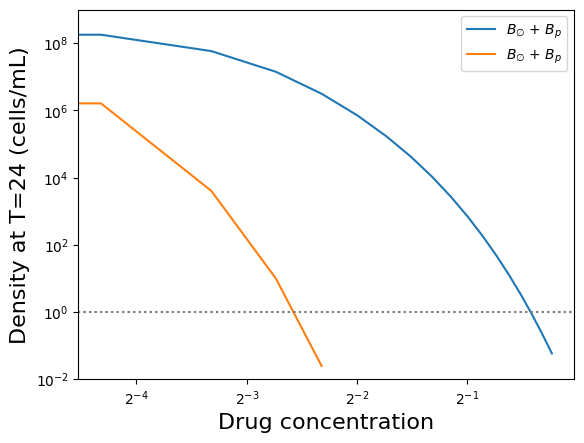

In [ ]:
fig, ax = plt.subplots()
plot_DR_BT(results_TC, A_results_TC, ax=ax)
plot_DR_BT(results_WT, A_results_WT, ax=ax)


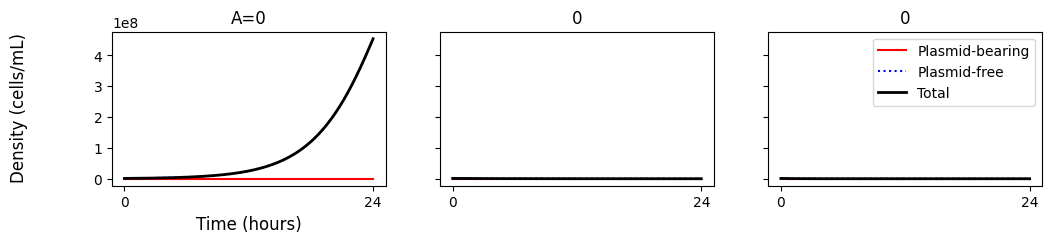

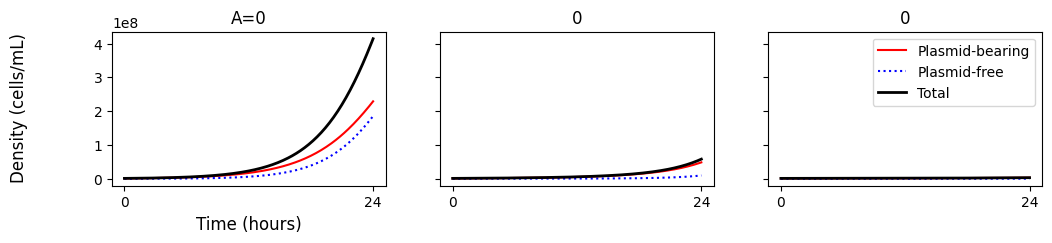

In [ ]:
# powers = np.arange(.0,30.0)  # array of powers of two exponents
#kappas=1.0 / np.power(2.0, powers)

A_idx = [i for i in range(0, len(A_results_WT), 2)]

plot_DR_simulations(results_WT, A_results_WT, A_idx)
plot_DR_simulations(results_TC, A_results_TC, A_idx)